In [12]:
from IPython.display import Image
%matplotlib inline

In [253]:
from collections import defaultdict, OrderedDict
import os

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
from matplotlib import cycler

import constants as c
SUM_OF_SCORES = 'Sum of scores'

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.
    This function creates a RadarAxes projection and registers it.
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            return self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def spider_plot_preprocess_metrics(pd_mean, labels):
    # store maximum values per rank
    rank_to_max_fp = defaultdict()
    rank_to_max_tp = defaultdict()
    rank_to_max_unifrac = defaultdict()
    rank_to_max_l1norm = defaultdict()
    rank_to_max_recall = defaultdict()
    rank_to_max_precision = defaultdict()
    for rank in c.PHYLUM_SPECIES:
        pd_rank = pd_mean.loc[(pd_mean.index.get_level_values('rank') == rank) & (pd_mean.index.get_level_values('tool') != c.GS)]
        rank_to_max_fp[rank] = pd_rank[c.FP].max()
        rank_to_max_tp[rank] = pd_rank[c.TP].max()
        rank_to_max_l1norm[rank] = pd_rank[c.L1NORM].max()
        rank_to_max_recall[rank] = pd_rank[c.RECALL].max()
        rank_to_max_precision[rank] = pd_rank[c.PRECISION].max()
    pd_rank = pd_mean.loc[(pd_mean.index.get_level_values('rank') == 'rank independent') & (pd_mean.index.get_level_values('tool') != c.GS)]
    rank_to_max_unifrac['rank independent'] = pd_rank[c.UNIFRAC].max()

    tool_to_rank_to_metric_to_value = defaultdict(lambda: defaultdict(dict))
    for (rank, tool), g in pd_mean.groupby(['rank', 'tool']):
        if tool not in labels:
            continue
        if rank == 'rank independent':
            # relative values
            tool_to_rank_to_metric_to_value[tool][rank][c.UNIFRAC] = (g[c.UNIFRAC].values[0] / (rank_to_max_unifrac[rank]) if rank_to_max_unifrac[rank] > 0 else g[c.UNIFRAC].values[0])
        elif rank in c.PHYLUM_SPECIES:
            # absolute values
            tool_to_rank_to_metric_to_value[tool][rank][c.RECALL+'absolute'] = g[c.RECALL].values[0] if len(g[c.RECALL].values) > 0 else None
            tool_to_rank_to_metric_to_value[tool][rank][c.PRECISION+'absolute'] = g[c.PRECISION].values[0] if len(g[c.PRECISION].values) > 0 else None
            tool_to_rank_to_metric_to_value[tool][rank][c.BRAY_CURTIS+'absolute'] = g[c.BRAY_CURTIS].values[0] if len(g[c.BRAY_CURTIS].values) > 0 else None

            # relative values
            if rank_to_max_recall[rank] > 0:
                tool_to_rank_to_metric_to_value[tool][rank][c.RECALL] = (g[c.RECALL].values[0] / rank_to_max_recall[rank]) if len(g[c.RECALL].values) > 0 else None
            else:
                tool_to_rank_to_metric_to_value[tool][rank][c.RECALL] = g[c.RECALL].values[0] if len(g[c.RECALL].values) > 0 else None

            if rank_to_max_precision[rank] > 0:
                tool_to_rank_to_metric_to_value[tool][rank][c.PRECISION] = (g[c.PRECISION].values[0] / rank_to_max_precision[rank]) if len(g[c.PRECISION].values) > 0 else None
            else:
                tool_to_rank_to_metric_to_value[tool][rank][c.PRECISION] = g[c.PRECISION].values[0] if len(g[c.PRECISION].values) > 0 else None

            if rank_to_max_l1norm[rank] > 0:
                tool_to_rank_to_metric_to_value[tool][rank][c.L1NORM] = (g[c.L1NORM].values[0] / rank_to_max_l1norm[rank]) if len(g[c.L1NORM].values) > 0 else None
            else:
                tool_to_rank_to_metric_to_value[tool][rank][c.L1NORM] = g[c.L1NORM].values[0] if len(g[c.L1NORM].values) > 0 else None

            if rank_to_max_fp[rank] > 0:
                tool_to_rank_to_metric_to_value[tool][rank][c.FP] = (g[c.FP].values[0] / rank_to_max_fp[rank]) if len(g[c.FP].values) else None
            else:
                tool_to_rank_to_metric_to_value[tool][rank][c.FP] = g[c.FP].values[0] if len(g[c.FP].values) else None

            if rank_to_max_tp[rank] > 0:
                tool_to_rank_to_metric_to_value[tool][rank][c.TP] = (g[c.TP].values[0] / rank_to_max_tp[rank]) if len(g[c.TP].values) else None
            else:
                tool_to_rank_to_metric_to_value[tool][rank][c.TP] = g[c.TP].values[0] if len(g[c.TP].values) else None
    return tool_to_rank_to_metric_to_value

def spider_plot(metrics, labels, rank_to_metric_to_toolvalues, output_dir, file_name, colors, grid_points=None, fill=False, absolute=False):
    N = len(labels)
    if N < 3:
        return []
    theta = radar_factory(N, frame='polygon')
    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=3, subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=1.25, hspace=0.1, top=0.87, bottom=0.45)

    for ax, rank in zip(axes.flat, c.PHYLUM_SPECIES):
        if grid_points:
            ax.set_rgrids(grid_points, fontsize='xx-small')
        else:
            ax.set_rgrids([0.2, 0.4, 0.6, 0.8], ('', '', '', ''))  # get rid of the labels of the grid points
        ax.set_title(rank, weight='bold', size=9, position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')

        # select only metrics in metrics list
        metrics_subdict = OrderedDict((metric, rank_to_metric_to_toolvalues[rank][metric]) for metric in metrics)
        it = 1
        metric_to_toolindex = []
        for d, color in zip(metrics_subdict.values(), colors):
            # store index of tools without a value for the current metric
            metric_to_toolindex.append([i for i, x in enumerate(d) if x is None or np.isnan(x)])
            d = [0 if x is None or np.isnan(x) else x for x in d]

            ax.plot(theta, d, '--', color=color, linewidth=2, dashes=(it, 1))
            if fill:
                ax.fill(theta, d, facecolor=color, alpha=0.25)
            it += 1
        ax.set_varlabels(labels)

        ax.set_rmax(1)

        # color red label of tools without a value for at least one metric
        xticklabels = ax.get_xticklabels()
        for metric in metric_to_toolindex:
            for toolindex in metric:
                xticklabels[toolindex].set_color([1, 0, 0])

        angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('right')
            else:
                label.set_horizontalalignment('left')

        # move tick labels closer to plot and set font size
        for xticklabel in xticklabels:
            xticklabel.set_position((0,.20))
            xticklabel.set_fontsize('x-small')

    if absolute:
        metrics = [metric[:-8] for metric in metrics]

    ax = axes[0, 0]
    legend = ax.legend(metrics, loc=(2.0 - 0.353 * len(metrics), 1.25),
                       labelspacing=0.1, fontsize='small', ncol=len(metrics), frameon=False)
    ax.add_artist(legend)
    
    r = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)
    ax.legend([r], ["a"], loc=(- 0.353 * len(metrics), 1.25), fontsize='large', frameon=False)

    fig.savefig(os.path.join(output_dir, file_name + '.pdf'), dpi=100, format='pdf', bbox_inches='tight')
    fig.savefig(os.path.join(output_dir, file_name + '.png'), dpi=100, format='png', bbox_inches='tight')
    #plt.close(fig)
    return [fig]

def plot_ranks_by_tool(labels, pd_grouped, output_dir, file_name):
    cols = pd_grouped.columns
    pd_mean = pd_grouped.groupby(['rank', 'tool'], sort=False)[cols].mean()
    pd_std = pd_grouped.groupby(['rank', 'tool'], sort=False)[cols].std()
    
    metrics = (c.RECALL, c.PRECISION, c.PRECISION_UNFILTERED, c.L1NORM)

    with plt.style.context("seaborn"):    
        fig, axes = plt.subplots(figsize=(18, 6), nrows=2, ncols=5, sharex=True, sharey=True)
        clrs = "#e66101 #5e3c99 k #4d9221".split(" ")
    
        for ax, label in zip(axes.flat, labels):
            epochs = c.ALL_RANKS[:-1]
            for i, metric in enumerate(metrics):
                meanst = pd_mean.query(f"tool == ['{label}']")[metric].dropna().reindex(index=zip(epochs, [label]*len(epochs)))
                sdt = pd_std.query(f"tool == ['{label}']")[metric].dropna().reindex(index=zip(epochs, [label]*len(epochs)))
                if metric == c.L1NORM:
                    # L1 norm goes from 0 to 2, so let's make it 0-1
                    meanst /= 2
                    sdt /= 2
                ax.plot(epochs, meanst, label=label, c=clrs[i])
                ax.set_ylim([0, 1])
                ax.set_xlim([0, len(epochs)-1])

                if metric != c.PRECISION_UNFILTERED:
                    ax.fill_between(epochs, meanst-sdt, meanst+sdt ,alpha=0.3, facecolor=clrs[i])
                ax.set_title(label)

                props = {"rotation" : 45, "horizontalalignment": 'right'}
                plt.setp(ax.get_xticklabels(), **props)
                ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))


        new_metrics = []
        for m in metrics:
            if m == c.PRECISION:
                new_metrics.append(m + " (1% filtered)")
            else:
                new_metrics.append(m)

        ax = axes[0, 0]
        legend = ax.legend(new_metrics, loc=(2.0 - 0.353 * len(metrics), 1.25), labelspacing=0.1, fontsize=16, ncol=len(metrics), frameon=False)          
        
        ax.add_artist(legend)

        r = matplotlib.patches.Rectangle((0,0), 1, 1, fill=False, edgecolor='none', visible=False)
        ax.legend([r], ["b"], loc=(-.5, 1.25), fontsize=22, frameon=False)
        
        fig.savefig(os.path.join(output_dir, file_name + '.pdf'), dpi=100, format='pdf', bbox_inches='tight')
        fig.savefig(os.path.join(output_dir, file_name + '.png'), dpi=100, format='png', bbox_inches='tight')
    #plt.close(fig)
    return [fig]


def highscore_table(metrics, useranks=None):
    """Compile a ranking table like Figure 3c of CAMI publication.
    
    Note that Figure 3c took into account mean scores for all samples of one of the three
    complexity levels, i.e. 1 for low, 2 for medium, 5 for high.
    Here, I assume that we might be able to do that later, but for now I set "complexity"
    to "dummy".
    
    Parameters
    ----------
    metrics : pd.DataFrame
        Information about metrics of tool performance.
        Must contain columns: metric, rank, tool, value
    useranks : [str]
        Old default (CAMI 1): 'phylum', 'class', 'order', 'family', 'genus'
        Which ranks should be considered for rank dependent metrics.
        Here we decided to exclude e.g. species, because most profilers
        fail at that rank and we don't want to emphasize on this rank.
    Returns
    -------
    Pandas.DataFrame holding a high scoring table as in Figure 3c.
    """
    if useranks is None:
        useranks = c.ALL_RANKS[:7]

    pd_metrics = metrics.copy()
    pd_metrics.loc[pd_metrics[pd.isnull(pd_metrics['rank'])].index, 'rank'] = 'rank independent'

    sort_ascendingly = {c.L1NORM: True, c.UNIFRAC: True,
                        c.RECALL: False, c.PRECISION: False}

    # get rid of gold standard
    pd_metrics = pd_metrics[pd_metrics['tool'] != c.GS]

    # collecting rank scores
    posresults = []
    for (metric, sample, rank), g in pd_metrics.groupby(['metric', 'sample', 'rank']):
        if metric in sort_ascendingly:
            if ((rank in useranks) and (metric != c.UNIFRAC)) or ((rank == 'rank independent') and (metric == c.UNIFRAC)):
                res = g.groupby('tool').sum()
                res['position'] = res['value'].rank(method='min', ascending=sort_ascendingly[metric]) - 1
                res['metric'] = metric
                res['sample'] = sample
                res['rank'] = rank
                posresults.append(res)
    posresults = pd.concat(posresults)

    return posresults.groupby(['metric', 'tool'])['position'].sum().to_frame(), useranks

    # reformat like Figure 3c
    os = []
    for metric, g in posresults.groupby('metric'):
        highscore = g.groupby('tool')['position'].sum().sort_values()
        os.append(pd.DataFrame(["%s (%i)" % (idx, pos) for idx, pos in highscore.iteritems()], columns=[metric]))

    # return reformatted table
    return pd.concat(os, axis=1)  #.T.loc[['Recall', 'Precision', 'L1 norm error', 'Unweighted Unifrac error'],:]

def get_formatted_pd_rankings(pd_rankings, labels):
    df_list = []
    
    pd_plot = pd_rankings.reset_index().pivot(index='tool', columns='metric')
    pd_plot[SUM_OF_SCORES] = pd_plot.sum(axis=1)
    labels_to_remove = set(pd_plot.index)- set(labels)
    for label in labels_to_remove:
        pd_plot.drop(index=label, inplace=True)
    pd_plot = pd_plot.reindex(labels)

    for metric, g in pd_rankings.groupby(level=0):
        for label in labels_to_remove:
            g = g.drop(index=(metric, label))
        df = g.reset_index().sort_values('position')
        df_list.append(pd.DataFrame({metric: df['tool'].tolist(), 'score' + metric: df['position'].tolist()}))
    df_sum = pd_rankings.groupby(['tool'])['position'].sum().reset_index().sort_values('position')
    df_list.append(
        pd.DataFrame({SUM_OF_SCORES: df_sum['tool'].tolist(), 'score' + SUM_OF_SCORES: df_sum['position'].tolist()}))
    pd_show = pd.concat(df_list, axis=1).dropna()

    return pd_show, pd_plot

def clean_scores(scores):
    new_scores = scores.copy()
    new_columns = [s for s in scores.columns if not s.startswith('score')]
    for column in new_columns:
        new_column_name = column
        if column == "Purity":
            new_column_name = "Purity (1% filtered)"
        new_scores[new_column_name] = scores[[column, f'score{column}']].apply(lambda x: "{} ({:.0f})".format(*x), axis=1)
        del new_scores[f'score{column}']
        if column == "Purity":
            del new_scores["Purity"]
    return new_scores[["Completeness", "Purity (1% filtered)", "L1 norm error", "Sum of scores"]]

def plot_scores_table(scores):
    from matplotlib.backends.backend_pdf import PdfPages
    
    new_scores = clean_scores(scores)
    
    new_index = dict(zip(list(new_scores.index), ["1st", "2nd", "3rd"] + [f"{c}th" for c in range(4, 11)]))
    new_scores = new_scores.rename(index=new_index)

    df = new_scores

    #https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
    fig, ax = plt.subplots(figsize=(12,.5))
    ax.axis('tight')
    ax.axis('off')
    #the_table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    the_table = pd.plotting.table(ax, df, edges='open', loc="top")
    the_table.scale(1,1.5)
    table_props = the_table.properties()
    table_cells = table_props['celld']
    for ((i, j), cell) in table_cells.items():
        props = {'horizontalalignment': 'left'}
        if i == 0:
            props["fontweight"] = "bold"
            cell.visible_edges = "horizontal"
        plt.setp(cell.get_text(), **props)

    #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
    pp = PdfPages("figures/scores.pdf")
    pp.savefig(fig, bbox_inches='tight')
    pp.close()
    
    return [fig]

def plot_all(pd_metrics, labels, output_dir, metrics_for_plot_rel, useranks=c.ALL_RANKS[:8]):
    rank_to_metric_to_toolvalues = defaultdict(lambda : defaultdict(list))

    pd_copy = pd_metrics.copy()
    pd_copy.loc[pd_copy[pd.isnull(pd_copy['rank'])].index, 'rank'] = 'rank independent'
    # transform table
    pd_grouped = pd_copy.pivot_table(index=['rank', 'tool', 'sample'], columns='metric', values='value')

    # compute mean over samples and collapse rows
    cols = pd_grouped.columns
    pd_mean = pd_grouped.groupby(['rank', 'tool'], sort=False)[cols].mean()

    tool_to_rank_to_metric_to_value = spider_plot_preprocess_metrics(pd_mean, labels)

    #metrics_for_plot_rel = [c.UNIFRAC, c.L1NORM, c.RECALL, c.PRECISION, c.FP]
    metrics_for_plot_abs = [c.RECALL+'absolute', c.PRECISION+'absolute']

    present_labels = []
    for label in labels:
        if label not in tool_to_rank_to_metric_to_value:
            continue
        else:
            present_labels.append(label)
        for rank in c.PHYLUM_SPECIES:
            for metric in metrics_for_plot_rel + metrics_for_plot_abs:
                if metric in tool_to_rank_to_metric_to_value[label][rank]:
                    rank_to_metric_to_toolvalues[rank][metric].append(tool_to_rank_to_metric_to_value[label][rank][metric])
            #rank_to_metric_to_toolvalues[rank][c.UNIFRAC].append(tool_to_rank_to_metric_to_value[label]['rank independent'][c.UNIFRAC])
            ### TODO: bring back UNIFRAC
    
    #colors = "#4d9221 #e66101 k #5e3c99".split(" ")
    colors = "#e66101 #5e3c99 k #4d9221".split(" ")
    #colors = [plt.cm.tab10(2), plt.cm.tab10(0), plt.cm.tab10(3), 'k', 'm', 'y']
    #colors2 = ['r', 'k', 'olive']
    
    plots_list = spider_plot(metrics_for_plot_rel,
                             present_labels,
                             rank_to_metric_to_toolvalues,
                             output_dir,
                             'spider_plot_relative',
                             colors[:len(metrics_for_plot_rel)],
                             fill=True)
    
    plots_list += plot_ranks_by_tool(labels, pd_grouped, output_dir, "ranks_by_tool")

    pd_rankings, ranks_scored = highscore_table(pd_metrics, useranks)
    pd_show, pd_plot = get_formatted_pd_rankings(pd_rankings, labels)

    #pd_rankings, ranks_scored = highscore_table(pd_metrics)
    #pd_show_nospecies, pd_plot = get_formatted_pd_rankings(pd_rankings, labels)
    
    plots_list += plot_scores_table(pd_show)
    
    return plots_list

In [254]:
pd_metrics = pd.read_table("data/cami_ii_mg.tsv")

In [255]:
labels = list(pd_metrics['tool'].unique())[1:-1]  # remove gold standard and CAMIARKQuikr 1.0.0
output_dir = "figures/"
metrics_for_plot_rel = [c.RECALL, c.PRECISION, c.L1NORM]#, c.FP, c.UNIFRAC]

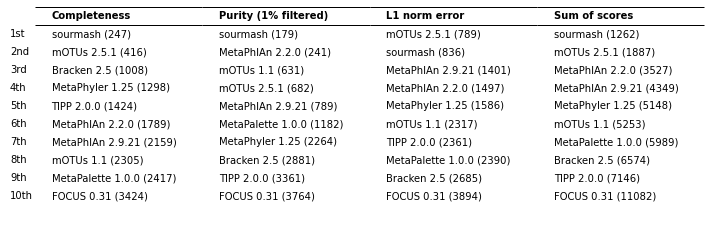

In [256]:
plist = plot_all(pd_metrics, labels, output_dir, metrics_for_plot_rel)

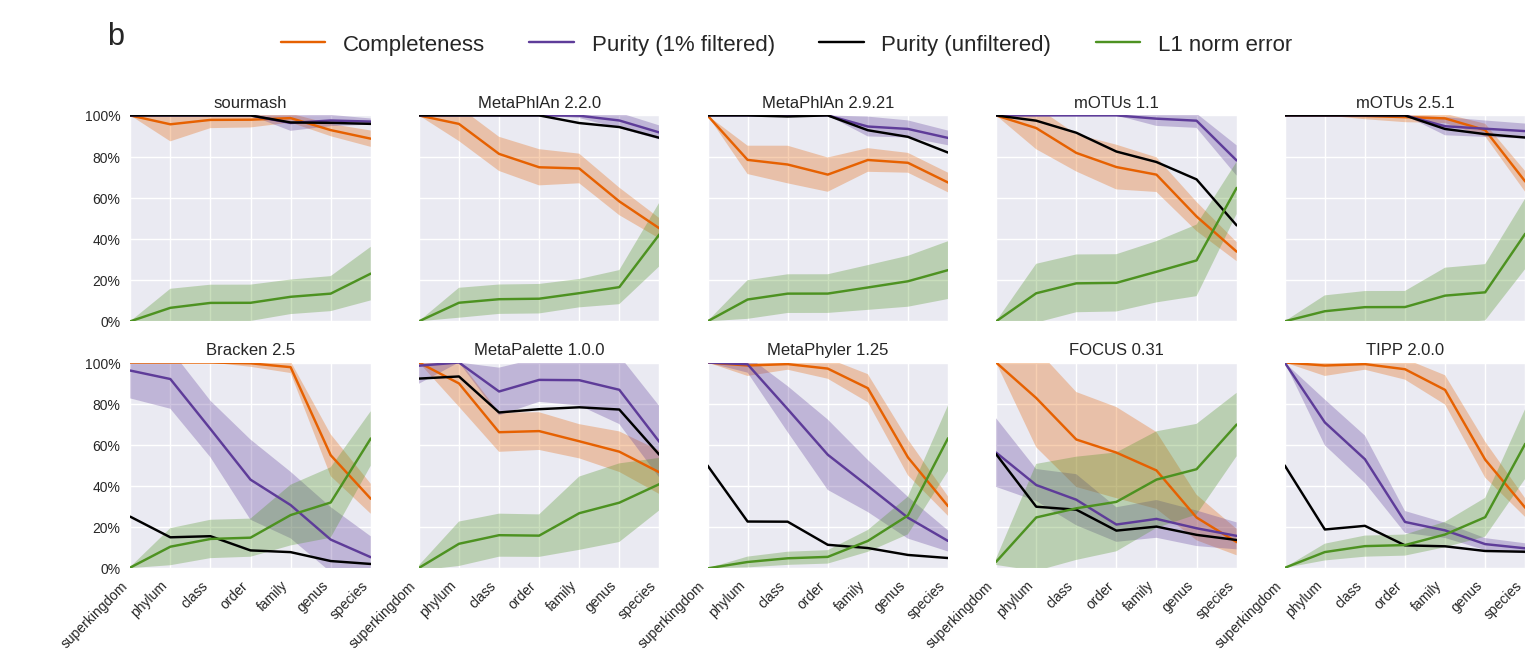

In [232]:
Image("figures/ranks_by_tool.png")

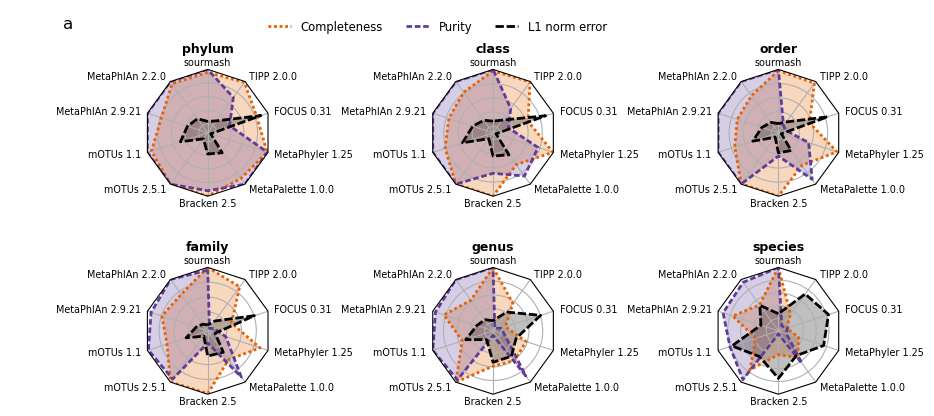

In [174]:
Image("figures/spider_plot_relative.png")